In [31]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions
%matplotlib inline
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import lmfit as fitter
import ETFunctions as et
from datetime import datetime
import matplotlib.dates as mdates

## Bring in data

In [32]:
DailyTempDiff = pd.read_pickle('.\DataFrames\DayTimeMeanSurfaceTemp.pkl')
DailyTempDiff.sort_index(axis=1,inplace=True)
HourlyWateruse = pd.read_pickle('.\DataFrames\HourlyWUmm.pkl')
HourlyWateruse.sort_index(axis=1,inplace=True)
TnRData = pd.read_pickle('.\DataFrames\TempAndMet.pkl')
TnRData.sort_index(axis=1,inplace=True)
SHFData = pd.read_pickle('.\DataFrames\HourlySoilHeatFluxTotalMJ.pkl')
SHFData.sort_index(axis=0,inplace=True)
RnDF = pd.read_pickle('.\DataFrames\NetRadiationMJ.pkl')
RnDF.sort_index(axis=0,inplace=True)

#Bring in estimated upper and lower canopy temp limits
HourlyTsBounds = pd.read_pickle('.\DataFrames\TsTaULDF.pkl')#pd.read_pickle('.\DataFrames\TsBoundData.pkl')
HourlyTsBounds.index.name = 'Date'
#the earliest common time
ECT = '2014-11-08 00:00:00'
#the latest common time
LCT = '2015-02-11 00:00:00'

Albedo = 0.23
Lattitude = -43.38
LongitudeTZ = 185
LongitudeML = 360 - 172.28
Cp = 1013 #Heat capacity of air Joule/kg/oC
D0 = 4000#1200
D6 = 2000
DB = 4
E = -0.0005
C1 = 1.2
C0 = 2.0
CB = 0.6
##Contract dataframes down to common index size
HourlyWateruse = HourlyWateruse.ix[ECT:LCT,:]
TnRData = TnRData.ix[ECT:LCT,:]
TnRData.index.name='Date'

HourlyWateruse.columns = HourlyWateruse.columns.swaplevel(0,1)

Irrigations = ['Low','Mid','High']
Cultivars = ['Dash','Omaka']
IrrigationsSub = ['High','Low']
DetailsPlotsList = [('Dash','High','1'),('Dash','High','3'),('Dash','High','4'),
          ('Dash','Low','1'),('Dash','Low','3'),('Dash','Low','4'),
          ('Omaka','High','1'),('Omaka','High','3'),('Omaka','High','4'),
          ('Omaka','Low','1'),('Omaka','Low','2'),('Omaka','Low','4')]

PlotList = [('Dash','Low','1'),('Dash','Low','2'),('Dash','Low','3'),('Dash','Low','4'),
('Dash','Mid','1'),('Dash','Mid','2'),('Dash','Mid','3'),('Dash','Mid','4'),
('Dash','High','1'),('Dash','High','2'),('Dash','High','3'),('Dash','High','4'),
('Omaka','Low','1'),('Omaka','Low','2'),('Omaka','Low','3'),('Omaka','Low','4'),
('Omaka','Mid','1'),('Omaka','Mid','2'),('Omaka','Mid','3'),('Omaka','Mid','4'),
('Omaka','High','1'),('Omaka','High','2'),('Omaka','High','3'),('Omaka','High','4')]

# Clean up all the crap

In [33]:
#Create a list of time to exclude where irrigation applications caused noise
IrrigationDates = ['2014-11-11','2014-11-18','2014-11-26','2014-12-02','2014-12-10','2014-12-16',
                    '2014-12-23','2014-12-30','2015-01-06','2015-01-13','2015-01-14']
#Remove data from daily dataframes
#DailyWaterUse = DailyWaterUse.ix[~DailyWaterUse.index.isin(IrrigationDates)]
DailyTempDiff = DailyTempDiff.ix[~DailyTempDiff.index.isin(IrrigationDates)]
#Make hourly exclusion index and remove data from hourly data frames
IrrigationDateTimes = []
for irrigDate in IrrigationDates:
    IrrigationDateTimes += pd.date_range(irrigDate,periods=24,freq='H')
HourlyWateruse = HourlyWateruse.ix[~HourlyWateruse.index.isin(IrrigationDateTimes)]
#Make 15 min exclusion index and remove data from 15min data frames
IrrigationDateTimes15 = []
for irrigDate in IrrigationDates:
    IrrigationDateTimes15 += pd.date_range(irrigDate,periods=96,freq='15T')
SHFData = SHFData.ix[~SHFData.index.isin(IrrigationDateTimes15)]
#Make 5 min exclusion index and remoe data from 5min data frames
IrrigationDateTimes5 = []
for irrigDate in IrrigationDates:
    IrrigationDateTimes5 += pd.date_range(irrigDate,periods=288,freq='5T')
TnRData = TnRData.ix[~TnRData.index.isin(IrrigationDateTimes5)]

In [34]:
NoMeasurementDates = ['2014-12-26','2014-12-27','2014-12-28']
DailyWaterUse = HourlyWateruse.resample('d').sum()
DailyWaterUse = DailyWaterUse.ix[~DailyWaterUse.index.isin(NoMeasurementDates)]
DailyWaterUse = DailyWaterUse.ix[DailyTempDiff.index,:]*-1
DailyWaterUse.sort_index(inplace=True)

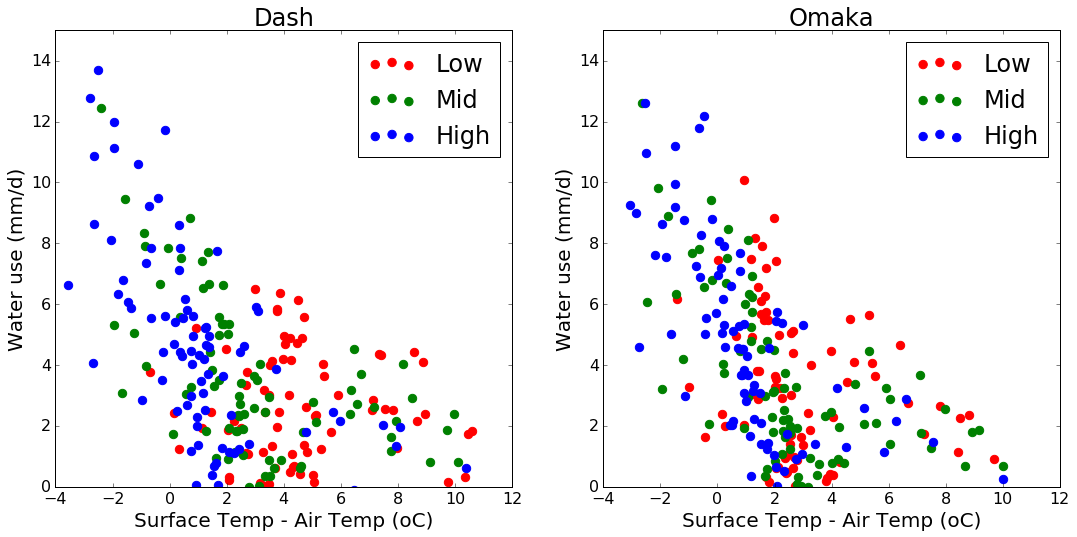

In [35]:
Comparison = plt.figure(figsize = (18,18))

Colors = ['red', 'green', 'blue']
Position = 1
for Cultivar in Cultivars:
    fig = Comparison.add_subplot(2,2,Position)
    ColorPosition = 0   
    for Irrigation in Irrigations:
        plt.scatter(DailyTempDiff.ix[:,('TsTa',Cultivar,Irrigation)],
                 DailyWaterUse.ix[:,(Cultivar,Irrigation)].mean(axis=1), 
                 color = Colors[ColorPosition],
                 label = Irrigation,
                 s = 70)
        ColorPosition += 1
    plt.ylabel('Water use (mm/d)', fontsize= 20)
    plt.xlabel('Surface Temp - Air Temp (oC)', fontsize= 20)
    plt.tick_params(labelsize = 16)
    plt.ylim(0,15)
    plt.xlim(-4,12)
    plt.legend(fontsize = 24)
    plt.title(Cultivar, fontsize = 24)
    Position +=1

## Make a data frame with hourly mean energy balance data in W/m2

### Bring in the cover Data

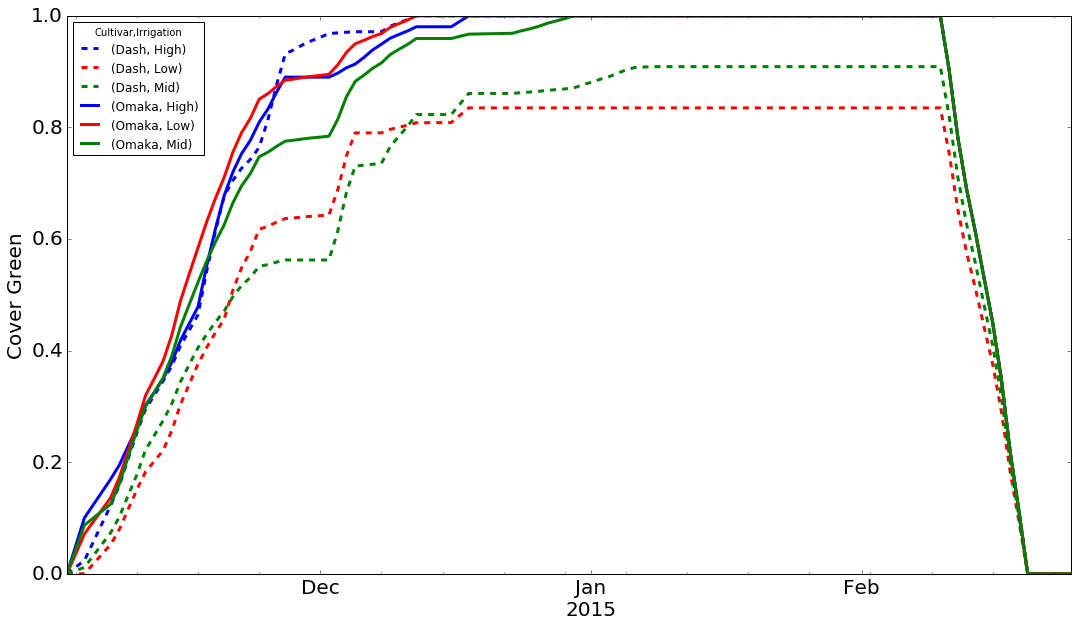

In [36]:
CoverData = pd.read_pickle('.\DataFrames\DailyFPAREstInt.pkl')
CoverData.sort_index(axis=1,inplace=True)
CoverData.groupby(level=['Cultivar','Irrigation'],axis=1).mean().plot(fontsize = 20, figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)
plt.ylabel('Cover Green', fontsize = 20)

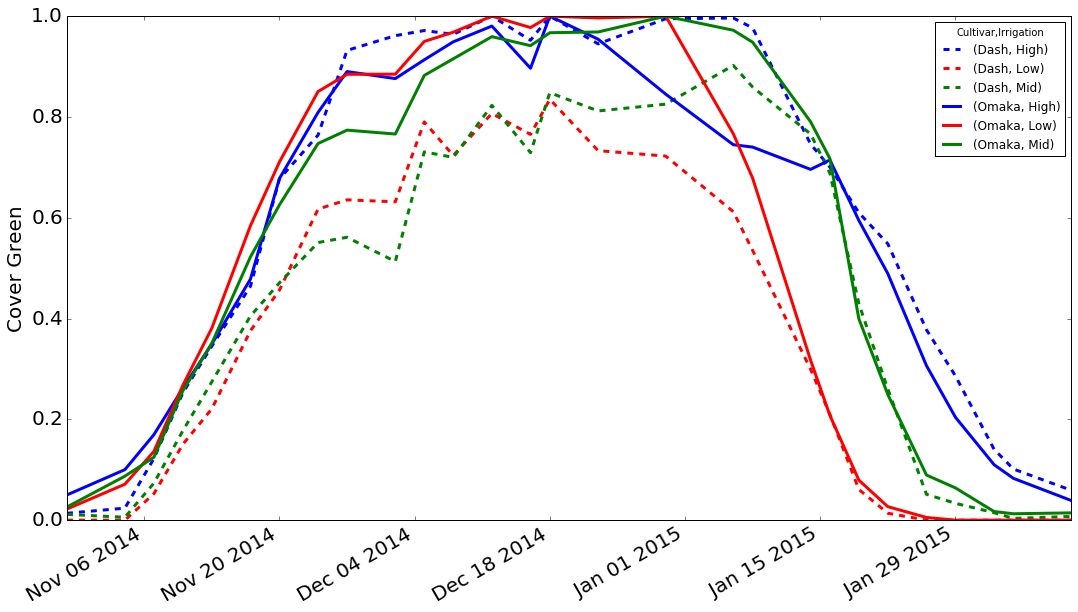

In [37]:
GreenCoverData = pd.read_pickle('.\DataFrames\FPARGreenEstimated.pkl')
GreenCoverData.sort_index(axis=1,inplace=True)
GreenCoverData.groupby(level=['Cultivar','Irrigation'],axis=1).mean().plot(fontsize = 20, figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)
plt.ylabel('Cover Green', fontsize = 20)

In [38]:
def makeSeries(Var,Frame):
    SSeries= Frame.ix[Var]
    SSeries.name = Var
    SSeries.index = SSeries.index.droplevel()
    SSeries.index = SSeries.index.droplevel()
    return SSeries

In [39]:
import math as math #import library for math functions
def RaZot(WindSpeed, Zu, h, Zot_Zom):
    """Aerodynamic resistance based on wind speed as described by Maes and Stepp 2012 in sm-1
    
    Original Reference: Thom and Oliver, 1977.  On Penmans equation for estimating regaional evaporation.  J Q R Meteorological Soc 98: 124
    
    Args:
        WindSpeed in m/s
        Zu in m is the hight that wind speed and temperature are measured 
        and is 1.2 m for a standard met station
        h in m is the height of the canopy 
    """
    if WindSpeed < 1.0:
        WindSpeed = 1
    d = (0.63*h)  # is the zero displacement height which is a complex function of canopy height and archicture
    Zot = (0.13*h) * Zot_Zom # is the roughness length of temperature and is also influenced by canopy height and archicture
    LN = math.log((Zu-d)/Zot)
    _ret = math.pow(LN,2)/(0.16*WindSpeed)
    return _ret 

In [40]:
#Start off data frame with net radiation data W/m2
#need to make this measured Rn not estimated
RnDF.name = 'Rn'
EnergyBalance = pd.DataFrame(RnDF)
#SoilHeatFlux Data is in W/m2 so join into frame
EnergyBalance = EnergyBalance.join(SHFData)

#Make hourly water use long
HourlyWateruse.index.name = 'Date'
HWULong = HourlyWateruse.unstack()
#Make hourly water use positive
PHWU = HWULong * -1
PHWU.name = 'PHWU'
#join into dataframe
EnergyBalance = EnergyBalance.join(PHWU)

#Get some other variables into dataframe
DateSet = EnergyBalance.ix[('Dash','Low','1'),:].index
TnRDataLong = TnRData.resample('h').mean().ix[DateSet].unstack()
LamdaSeries = makeSeries('lamda',TnRDataLong)
tempSeries = makeSeries('AirTemperature',TnRDataLong)
windSeries = makeSeries('Windspeed',TnRDataLong)
qSeries = makeSeries('q',TnRDataLong)
VPDSeries = makeSeries('VPD',TnRDataLong)

for plot in DetailsPlotsList:
    #Hourly Water use in mm is equal to kg/m2 need to multiply by latent heat of vapourisation to convert to MJ
    LESeries = np.multiply(EnergyBalance.ix[plot,'PHWU'], LamdaSeries)
    EnergyBalance.ix[plot,'HLEMJ'] = LESeries.values
    EnergyBalance.ix[plot,'Ta'] = tempSeries.values
    EnergyBalance.ix[plot,'u'] = windSeries.values
    EnergyBalance.ix[plot,'q'] = qSeries.values
    EnergyBalance.ix[plot,'VPD'] = VPDSeries.values
    EnergyBalance.ix[plot,'lamda'] = LamdaSeries.values

    
#then divide by duration (3600 seconds) to give latent heat in MW and divide by a million to convert to W
EnergyBalance.ix[:,'LE'] = EnergyBalance.ix[:,'HLEMJ']#/3600 * 1000000

#Calculate sensible heat and put into data frame
EnergyBalance.ix[:,'H'] = EnergyBalance.ix[:,'Rn'] - EnergyBalance.ix[:,'G'] - EnergyBalance.ix[:,'LE'] 

#Make the surface temperature data long and join into dataframe
TsDF = TnRData.ix[DateSet,'IR_SurfaceTemp']
TsDF.columns = HourlyWateruse.sort_index(axis=1).columns
TsLong = TsDF.unstack()
TsLong.name= 'Ts'
EnergyBalance = EnergyBalance.join(TsLong)
EnergyBalance.ix[:,'uVPD'] = EnergyBalance.ix[:,'u'] * EnergyBalance.ix[:,'VPD']
EnergyBalance.ix[:,'Ts-Ta'] = EnergyBalance.ix[:,'Ts'] - EnergyBalance.ix[:,'Ta']
EnergyBalance.ix[:,'qCp'] = EnergyBalance.ix[:,'q']*Cp
EnergyBalance.ix[:,'Cover'] = CoverData.ix[DateSet].bfill().unstack()
EnergyBalance.ix[:,'GreenCover'] = GreenCoverData.ix[DateSet].bfill().unstack()
EnergyBalance.ix[:,'Rn-G'] = EnergyBalance.ix[:,'Rn'] - EnergyBalance.ix[:,'G']
EnergyBalance.ix[:,'H/(Rn-G)'] = EnergyBalance.ix[:,'H'] / EnergyBalance.ix[:,'Rn-G']
EnergyBalance.ix[:,'abs(H/(Rn-G))'] = EnergyBalance.ix[:,'H/(Rn-G)'].abs()
EnergyBalance.ix[:,'(Ts-Ta)qCp'] = EnergyBalance.ix[:,'Ts-Ta'] * (EnergyBalance.ix[:,'qCp'])
EnergyBalance.ix[:,'Ra'] =  (EnergyBalance.ix[:,'(Ts-Ta)qCp']*86400)/EnergyBalance.ix[:,'H']
#EnergyBalance.ix[:,'Ra'] = EnergyBalance.ix[:,'Ra'].abs()
EnergyBalance.ix[:,'abs(H/(Rn-G))/Ra'] = EnergyBalance.ix[:,'abs(H/(Rn-G))']/EnergyBalance.ix[:,'Ra']

#Join in estimated upper canopy temp limits
EnergyBalance.ix[:,'TsUL-Ta'] = HourlyTsBounds.resample('h').mean().ix[DateSet].bfill().unstack()

#Calculate some more stuff
#EnergyBalance.ix[:,'(TsLL-Ta)qCp'] = np.multiply(EnergyBalance.ix[:,'TsLL-Ta'] , EnergyBalance.ix[:,'qCp'])
EnergyBalance.ix[:,'maxH/(Rn-G)'] = 1.0 - EnergyBalance.ix[:,'GreenCover']*-0.4 
EnergyBalance.ix[:,'depH/(Rn-G)'] = EnergyBalance.ix[:,'maxH/(Rn-G)'] - EnergyBalance.ix[:,'H/(Rn-G)']
EnergyBalance.ix[:,'(TsUL-Ta)qCp'] = np.multiply(EnergyBalance.ix[:,'TsUL-Ta'] , EnergyBalance.ix[:,'qCp'])
EnergyBalance.ix[:,'TsUL'] = EnergyBalance.ix[:,'Ta'] + EnergyBalance.ix[:,'TsUL-Ta']
EnergyBalance.ix[:,'ToUL'] = EnergyBalance.ix[:,'TsUL'] + EnergyBalance.ix[:,'VPD'] * 1
EnergyBalance.ix[:,'ToUL-Ta'] = EnergyBalance.ix[:,'ToUL'] - EnergyBalance.ix[:,'Ta']
EnergyBalance.ix[:,'(ToUL-Ta)qCp'] = np.multiply(EnergyBalance.ix[:,'ToUL-Ta'] , EnergyBalance.ix[:,'qCp'])

EnergyBalance.ix[:,'To'] = EnergyBalance.ix[:,'Ts'] + EnergyBalance.ix[:,'VPD'] * 1
EnergyBalance.ix[:,'To-Ta'] = EnergyBalance.ix[:,'To'] - EnergyBalance.ix[:,'Ta']
EnergyBalance.ix[:,'(To-Ta)qCp'] = EnergyBalance.ix[:,'To-Ta'] * EnergyBalance.ix[:,'qCp']
EnergyBalance.ix[:,'(Ts-Ta)/(TsUL-Ta)'] = EnergyBalance.ix[:,'Ts-Ta'] / EnergyBalance.ix[:,'TsUL-Ta']
EnergyBalance.ix[:,'(To-Ta)/(ToUL-Ta)'] = EnergyBalance.ix[:,'To-Ta'] / EnergyBalance.ix[:,'ToUL-Ta']
EnergyBalance.ix[:,'(To-Ta)aCp/(ToUL-Ta)qCp'] = EnergyBalance.ix[:,'(To-Ta)qCp'] / EnergyBalance.ix[:,'(ToUL-Ta)qCp']
EnergyBalance.ix[:,'ulim'] = [max(EnergyBalance.ix[x,'u'],1) for x in range(EnergyBalance.ix[:,'u'].index.size)]
EnergyBalance.ix[:,'Ra'] = 1/(0.015 * EnergyBalance.ix[:,'ulim'])
EnergyBalance.ix[:,'EstH'] = (((EnergyBalance.ix[:,'qCp']/1e6)/EnergyBalance.ix[:,'Ra'])*86400 * EnergyBalance.ix[:,'To-Ta'])/EnergyBalance.ix[:,'lamda']/25
EnergyBalance.ix[:,'H/lamda'] = EnergyBalance.ix[:,'H']/EnergyBalance.ix[:,'lamda']

In [41]:
import math as math #import library for math functions
def RaFAO(WindSpeed, h):
    """Aerodynamic resistance based on wind speed as described by Maes and Stepp 2012 in sm-1
    
    Original Reference: Thom and Oliver, 1977.  On Penmans equation for estimating regaional evaporation.  J Q R Meteorological Soc 98: 124
    
    Args:
        WindSpeed in m/s
        Zu in m is the hight that wind speed and temperature are measured 
        and is 1.2 m for a standard met station
        h in m is the height of the canopy 
    """
    if WindSpeed < 1.0:
        WindSpeed = 1
    left = np.log((2-(2/3)*h)/(0.123*h))
    right =  np.log((2-(2/3)*h)/(0.1* 0.123*h))
    denom = 0.42**2*WindSpeed
    _ret = (left*right)/denom
        
    return _ret 

In [42]:
RaFAO(1,0.12)

200.68848465070408

In [43]:
208.0/1

208.0

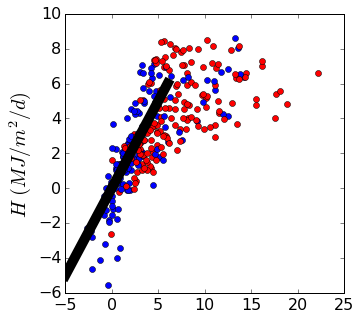

In [44]:
Comparison = plt.figure(figsize = (5,5))
Tit = ['a','b','c','d','e','f','g','h','i','j','k']
Colors = ['blue','red']
FillColors = ['White','White','blue','red']
Lines = ['--','-']
Position = 1
fig = Comparison.add_subplot(1,1,Position)
LinePos=0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = EnergyBalance.Rn > 0.05 
        yData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'H/lamda'].groupby(level='Date',axis=0).mean().resample('d').sum()
        xData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'EstH'].groupby(level='Date',axis=0).mean().resample('d').sum()
        #Upp = yData + ySEM
        #Low = yData - ySEM
        #xData = yData.index.get_level_values('Date')
        plt.plot(xData,yData, 'o', color = Colors[ColorPosition],label = Cultivar+Irrigation,linewidth = 3)
        #plt.fill_between(xData,Upp,Low,color = Colors[ColorPosition],alpha=0.2)
        ColorPosition += 1
    plt.ylabel('$H$ $(MJ/m^2/d)$', fontsize= 20)
    #plt.ylim(-17,25)
    LinePos +=1
    #fig.xaxis.set_major_locator(mdates.MonthLocator())
    #fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
    #plt.xlim('2014-11-01','2015-02-15')
    #plt.text('2014-11-02',22, 'a', fontsize = 24)
plt.tick_params(labelsize = 16)
Position +=2
factor = 1
xs = [-5*factor,6*factor]
plt.plot(xs,np.divide(xs,factor),'-',linewidth=10,color='k')



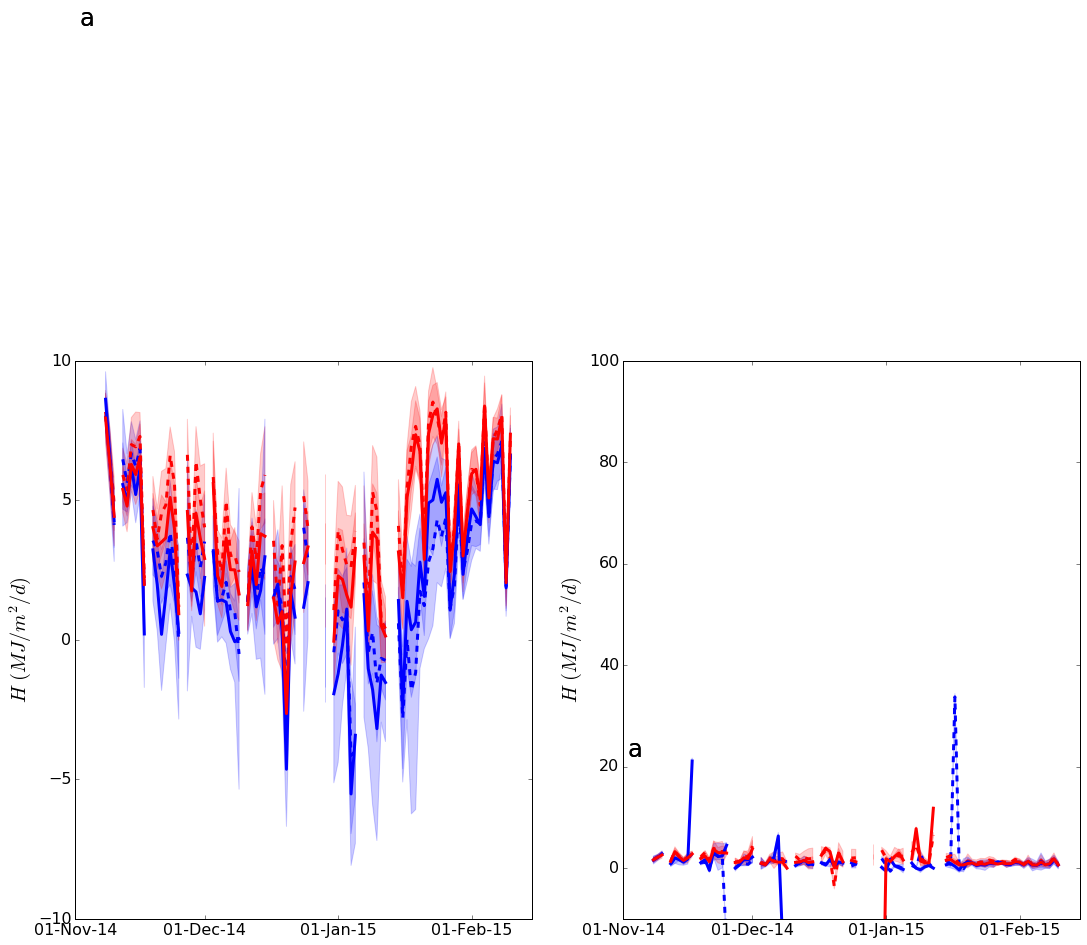

In [45]:
Comparison = plt.figure(figsize = (18,10))
Tit = ['a','b','c','d','e','f','g','h','i','j','k']
Colors = ['blue','red']
FillColors = ['White','White','blue','red']
Lines = ['--','-']
Position = 1
fig = Comparison.add_subplot(1,2,Position)
LinePos=0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = EnergyBalance.Rn > 0.05 
        yData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'H/lamda'].groupby(level='Date',axis=0).mean().resample('d').sum()
        ySEM = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'H/lamda'].groupby(level='Date',axis=0).std().resample('d').sum()
        Upp = yData + ySEM
        Low = yData - ySEM
        xData = yData.index.get_level_values('Date')
        plt.plot(xData,yData, Lines[LinePos], color = Colors[ColorPosition],label = Cultivar+Irrigation,linewidth = 3)
        plt.fill_between(xData,Upp,Low,color = Colors[ColorPosition],alpha=0.2)
        ColorPosition += 1
    plt.ylabel('$H$ $(MJ/m^2/d)$', fontsize= 20)
    #plt.ylim(-17,25)
    LinePos +=1
    fig.xaxis.set_major_locator(mdates.MonthLocator())
    fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
    plt.xlim('2014-11-01','2015-02-15')
    plt.text('2014-11-02',22, 'a', fontsize = 24)
plt.tick_params(labelsize = 16)
Position +=2

Tit = ['a','b','c','d','e','f','g','h','i','j','k']
Colors = ['blue','red']
FillColors = ['White','White','blue','red']
Lines = ['--','-']
Position = 1
fig = Comparison.add_subplot(1,2,2)
LinePos=0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = EnergyBalance.Rn > 0.05 
        denom = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'H/lamda'].groupby(level='Date',axis=0).mean().resample('d').sum()
        yData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'EstH'].groupby(level='Date',axis=0).mean().resample('d').sum()/denom
        ySEM = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'EstH'].groupby(level='Date',axis=0).std().resample('d').sum()
        Upp = yData + ySEM
        Low = yData - ySEM
        xData = yData.index.get_level_values('Date')
        plt.plot(xData,yData, Lines[LinePos], color = Colors[ColorPosition],label = Cultivar+Irrigation,linewidth = 3)
        plt.fill_between(xData,Upp,Low,color = Colors[ColorPosition],alpha=0.2)
        ColorPosition += 1
    plt.ylabel('$H$ $(MJ/m^2/d)$', fontsize= 20)
    plt.ylim(-10,100)
    LinePos +=1
    fig.xaxis.set_major_locator(mdates.MonthLocator())
    fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
    plt.xlim('2014-11-01','2015-02-15')
    plt.text('2014-11-02',22, 'a', fontsize = 24)
plt.tick_params(labelsize = 16)
Position +=2



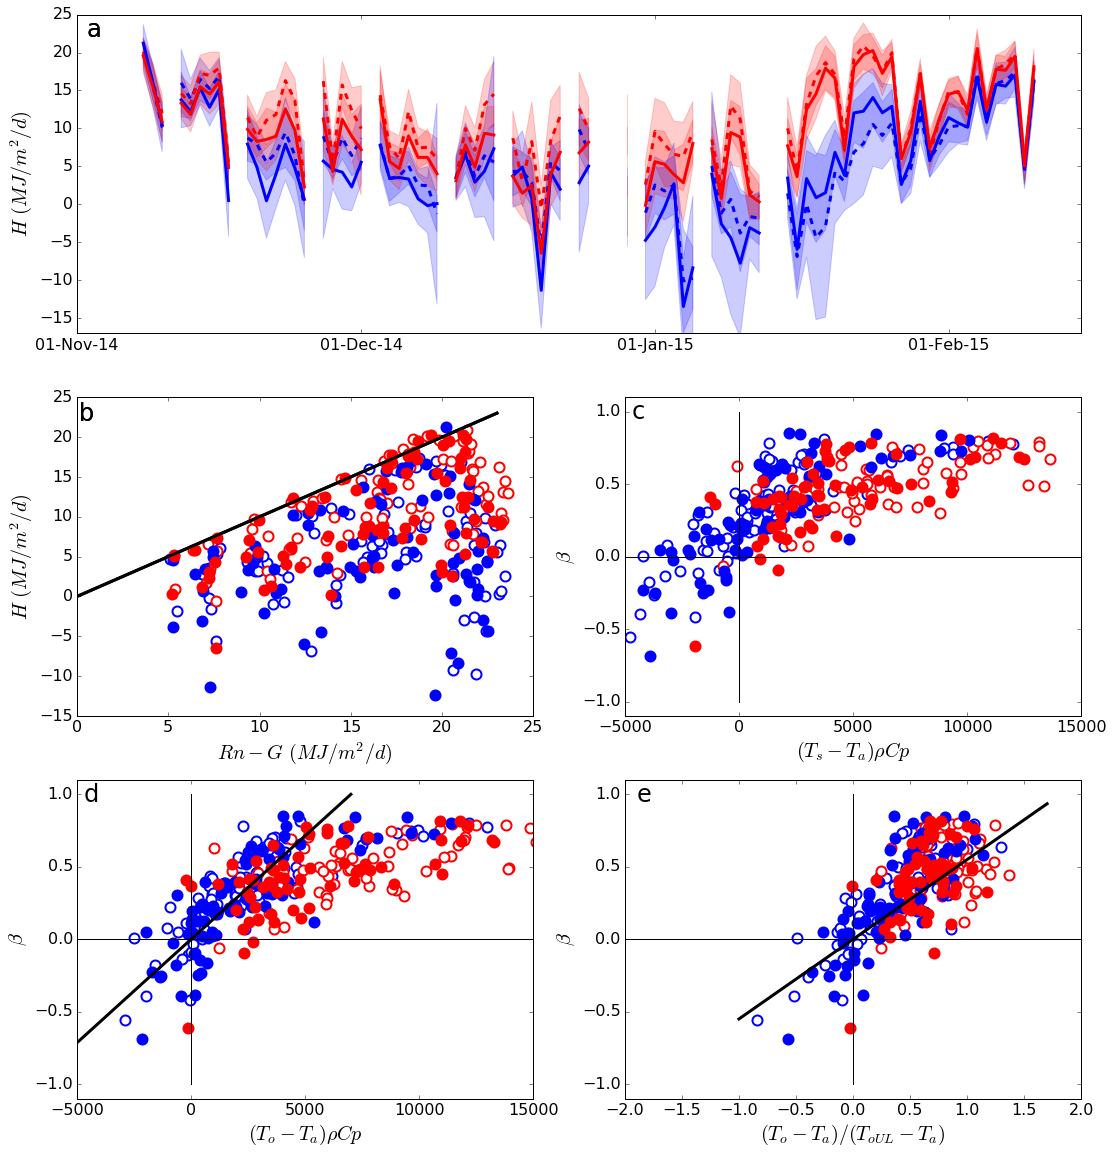

In [46]:
# A)
Comparison = plt.figure(figsize = (18,40))
Tit = ['a','b','c','d','e','f','g','h','i','j','k']
Colors = ['blue','red']
FillColors = ['White','White','blue','red']
Lines = ['--','-']
Position = 1
fig = Comparison.add_subplot(6,1,Position)
LinePos=0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = EnergyBalance.Rn > 0.05 
        yData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'H'].groupby(level='Date',axis=0).mean().resample('d').sum()
        ySEM = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'H'].groupby(level='Date',axis=0).std().resample('d').sum()
        Upp = yData + ySEM
        Low = yData - ySEM
        xData = yData.index.get_level_values('Date')
        plt.plot(xData,yData, Lines[LinePos], color = Colors[ColorPosition],label = Cultivar+Irrigation,linewidth = 3)
        plt.fill_between(xData,Upp,Low,color = Colors[ColorPosition],alpha=0.2)
        ColorPosition += 1
    plt.ylabel('$H$ $(MJ/m^2/d)$', fontsize= 20)
    plt.ylim(-17,25)
    LinePos +=1
    fig.xaxis.set_major_locator(mdates.MonthLocator())
    fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
    plt.xlim('2014-11-01','2015-02-15')
    plt.text('2014-11-02',22, 'a', fontsize = 24)
plt.tick_params(labelsize = 16)
Position +=2

# B)
fig = Comparison.add_subplot(6,2,Position)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.Rn > .1)
        yData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'H'].groupby(level='Date',axis=0).mean().resample('d').sum()
        xData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'Rn-G'].groupby(level='Date',axis=0).mean().resample('d').sum()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=10,mew=2)
        ColorPosition += 1
        FillPosition += 1
    plt.ylabel('$H$ $(MJ/m^2/d)$', fontsize= 20)
    plt.xlabel('$Rn-G$ $(MJ/m^2/d)$', fontsize= 20)
    plt.tick_params(labelsize = 16)
    plt.ylim(-15,25)
    plt.xlim(0,25)
    plt.text(0.1,22, 'b', fontsize = 24)
    plt.plot([0,23],[0,23],'-',color='k',linewidth=3)
Position +=1

# C)
fig = Comparison.add_subplot(6,2,Position)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0 
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.ix[:,'Rn-G'] > 0.5)&(EnergyBalance.ix[:,'LE'] > 0.1)\
        &(EnergyBalance.ix[:,'abs(H/(Rn-G))'] <1.05)&(EnergyBalance.ix[:,'uVPD']>0)\
        &(EnergyBalance.GreenCover>0.0)
        yData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'H/(Rn-G)'].groupby(level='Date',axis=0).mean().resample('d').mean()
        xData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'(Ts-Ta)qCp'].groupby(level='Date',axis=0).mean().resample('d').mean()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=10,mew=2)
        ColorPosition += 1
        FillPosition += 1
plt.plot([0,0],[-1,1],'k')
plt.plot([-15000,15000],[0,0],'k')
plt.ylabel(r'$\beta $', fontsize= 20)
plt.xlabel(r'$(T_s-T_a) \rho Cp$', fontsize= 20)
plt.tick_params(labelsize = 16)
plt.ylim(-1.1,1.1)
plt.xlim(-5000,15000)
plt.text(-4700, 0.95, 'c', fontsize = 24)
Position +=1

# D)
fig = Comparison.add_subplot(6,2,Position)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.ix[:,'Rn-G'] > 0.5)&(EnergyBalance.ix[:,'LE'] > 0.1)\
        &(EnergyBalance.ix[:,'abs(H/(Rn-G))'] <1.05)&(EnergyBalance.ix[:,'uVPD']>0)\
        &(EnergyBalance.GreenCover>0.0)
        yData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'H/(Rn-G)'].groupby(level='Date',axis=0).mean().resample('d').mean()
        xData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'(To-Ta)qCp'].groupby(level='Date',axis=0).mean().resample('d').mean()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=10,mew=2)
        ColorPosition += 1
        FillPosition += 1
plt.plot([0,0],[-1,1],'k')
plt.plot([-15000,15000],[0,0],'k')
plt.ylabel(r'$\beta $', fontsize= 20)
plt.xlabel(r'$(T_o-T_a) \rho Cp$', fontsize= 20)
plt.tick_params(labelsize = 16)
plt.ylim(-1.1,1.1)
plt.xlim(-5000,15000)
plt.text(-4700, 0.95, 'd', fontsize = 24)
Position +=1
plt.plot([-7000,7000],[-1,1],'-',color='k',linewidth=3)


# E)
fig = Comparison.add_subplot(6,2,Position)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.ix[:,'Rn-G'] > 0.5)&(EnergyBalance.ix[:,'LE'] > 0.1)\
        &(EnergyBalance.ix[:,'abs(H/(Rn-G))'] <1.05)&(EnergyBalance.ix[:,'uVPD']>0)\
        &(EnergyBalance.GreenCover>0) & (EnergyBalance.ix[:,'(To-Ta)/(ToUL-Ta)']>-10)\
        &(EnergyBalance.ix[:,'(Ts-Ta)/(TsUL-Ta)']<2)
        yData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'H/(Rn-G)'].groupby(level='Date',axis=0).mean().resample('d').mean()
        xData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'(To-Ta)/(ToUL-Ta)'].groupby(level='Date',axis=0).mean().resample('d').mean()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=10,mew=2)
        ColorPosition += 1
        FillPosition += 1
plt.plot([0,0],[-1,1],'k')
plt.plot([-15000,15000],[0,0],'k')
plt.ylabel(r'$\beta $', fontsize= 20)
plt.xlabel(r'$(T_o-T_a) / (T_{oUL}-T_a)$', fontsize= 20)
plt.tick_params(labelsize = 16)
plt.ylim(-1.1,1.1)
plt.xlim(-2,2)
plt.text(-1.9, 0.95, 'e', fontsize = 24)
Position +=1
plt.plot([-1.,1.7],[-0.55,0.935],'-',color='k',linewidth=3)

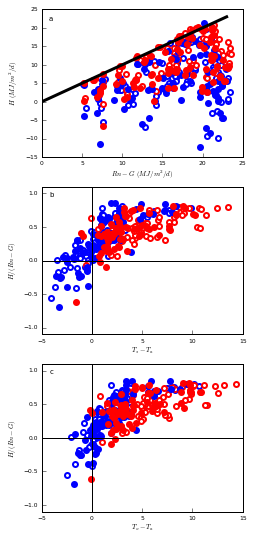

In [59]:
Comparison = plt.figure(figsize = (3.6,9))
# A)
fig = Comparison.add_subplot(3,1,1)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.Rn > .1)
        yData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'H'].groupby(level='Date',axis=0).mean().resample('d').sum()
        xData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'Rn-G'].groupby(level='Date',axis=0).mean().resample('d').sum()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=5,mew=2)
        ColorPosition += 1
        FillPosition += 1
plt.ylabel('$H$ $(MJ/m^2/d)$', fontsize= 7)
plt.xlabel('$Rn - G$ $(MJ/m^2/d)$', fontsize= 7)
plt.tick_params(labelsize = 6)
plt.ylim(-15,25)
plt.xlim(0,25)
plt.text(0.8,22, 'a', fontsize = 7)
plt.plot([0,23],[0,23],'-',color='k',linewidth=3)
plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on',labelsize=6)
plt.tick_params(axis='y', which='both', left='on',right='off', labelright='off',labelsize=6)
fig.xaxis.labelpad = 2

# B)
fig = Comparison.add_subplot(3,1,2)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0 
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.ix[:,'Rn-G'] > 0.5)&(EnergyBalance.ix[:,'LE'] > 0.1)\
        &(EnergyBalance.ix[:,'abs(H/(Rn-G))'] <1.05)&(EnergyBalance.ix[:,'uVPD']>0)\
        &(EnergyBalance.GreenCover>0.0)
        yData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'H/(Rn-G)'].groupby(level='Date',axis=0).mean().resample('d').mean()
        xData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'Ts-Ta'].groupby(level='Date',axis=0).mean().resample('d').mean()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=5,mew=2)
        ColorPosition += 1
        FillPosition += 1
plt.plot([0,0],[-1.1,1.1],'k')
plt.plot([-15000,15000],[0,0],'k')
plt.ylabel(r'$H/(Rn-G)$', fontsize= 7)
plt.xlabel(r'$T_s-T_a$', fontsize= 7)
plt.tick_params(labelsize = 6)
plt.ylim(-1.1,1.1)
plt.xlim(-5,15)
plt.text(-4.2, 0.95, 'b', fontsize = 7)
Position +=1
plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on',labelsize=6)
plt.tick_params(axis='y', which='both', left='on',right='off', labelright='off',labelsize=6)
fig.xaxis.labelpad = 2

# c)
fig = Comparison.add_subplot(3,1,3)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.ix[:,'Rn-G'] > 0.5)&(EnergyBalance.ix[:,'LE'] > 0.1)\
        &(EnergyBalance.ix[:,'abs(H/(Rn-G))'] <1.05)&(EnergyBalance.ix[:,'uVPD']>0)\
        &(EnergyBalance.GreenCover>0.0)
        yData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'H/(Rn-G)'].groupby(level='Date',axis=0).mean().resample('d').mean()
        xData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'To-Ta'].groupby(level='Date',axis=0).mean().resample('d').mean()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=5,mew=2)
        ColorPosition += 1
        FillPosition += 1
plt.plot([0,0],[-1.1,1.1],'k')
plt.plot([-15000,15000],[0,0],'k')
plt.ylabel(r'$H/(Rn-G)$', fontsize= 7)
plt.xlabel(r'$T_o-T_a$', fontsize= 7)
plt.tick_params(labelsize = 6)
plt.ylim(-1.1,1.1)
plt.xlim(-5,15)
plt.text(-4.2, 0.95, 'c', fontsize = 7)
Position +=1
#plt.plot([-7000,7000],[-1,1],'-',color='k',linewidth=3)
plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on',labelsize=6)
plt.tick_params(axis='y', which='both', left='on',right='off', labelright='off',labelsize=6)
fig.xaxis.labelpad = 2

Comparison.savefig('Fig_6.jpg',dpi=1000)

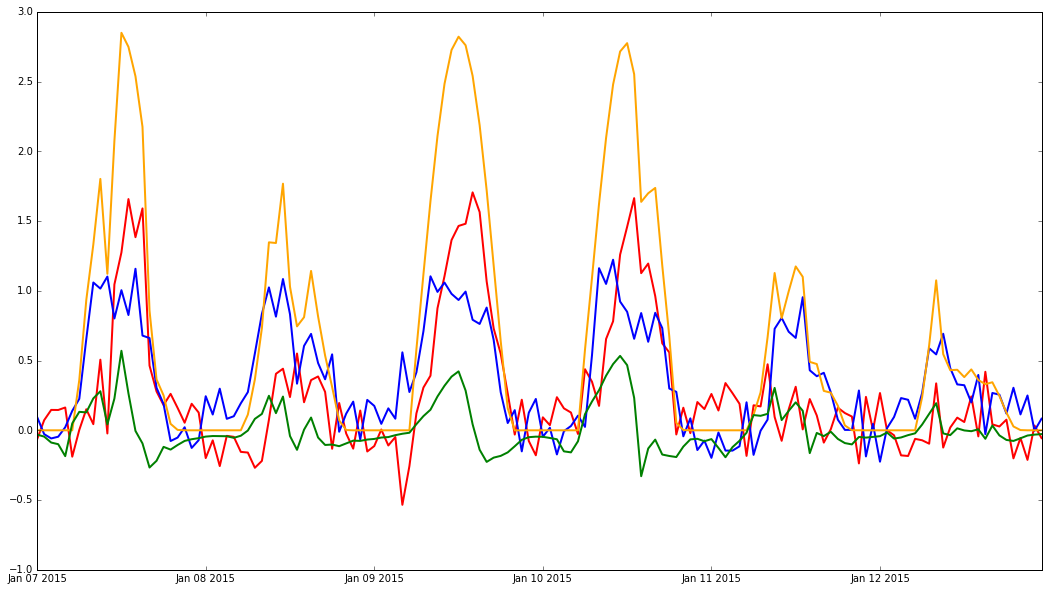

In [48]:
Graph = plt.figure(figsize=(18,10))
lines = ['--','--','-','-']
Widths = [1,2,1,2]
Pos = 3
for Cult in ['Dash']:#Cultivars:
    for Irr in ['Low']:#IrrigationsSub:
        HData = EnergyBalance.groupby(level=['Cultivar','Irrigation','Date'],axis=0).mean().ix[(Cult,Irr),'H'].ix['2015-01-07':'2015-01-12']
        LEData = EnergyBalance.groupby(level=['Cultivar','Irrigation','Date'],axis=0).mean().ix[(Cult,Irr),'LE'].ix['2015-01-07':'2015-01-12']
        RnData = EnergyBalance.groupby(level=['Cultivar','Irrigation','Date'],axis=0).mean().ix[(Cult,Irr),'Rn'].ix['2015-01-07':'2015-01-12']
        GData = EnergyBalance.groupby(level=['Cultivar','Irrigation','Date'],axis=0).mean().ix[(Cult,Irr),'G'].ix['2015-01-07':'2015-01-12']
        xData = HData.index
        plt.plot(xData,HData,lines[Pos],color='r',linewidth=Widths[Pos])
        plt.plot(xData,LEData,lines[Pos],color='b',linewidth=Widths[Pos])
        plt.plot(xData,RnData,lines[Pos],color='orange',linewidth=Widths[Pos])
        plt.plot(xData,GData,lines[Pos],color='g',linewidth=Widths[Pos])
        Pos+=1

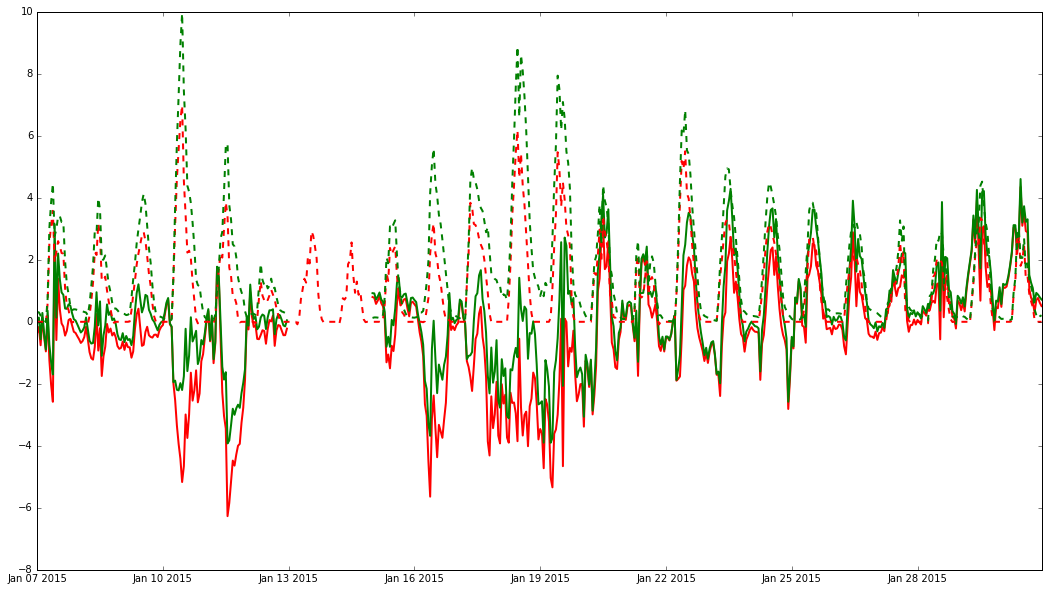

In [49]:
Graph = plt.figure(figsize=(18,10))
lines = ['--','--','-','-']
Widths = [1,2,1,2]
Dates = ['2015-01-07','2015-01-30']
Pos = 3
for Cult in ['Dash']:#Cultivars:
    for Irr in ['High']:#IrrigationsSub:
        TsTa = EnergyBalance.groupby(level=['Cultivar','Irrigation','Date'],axis=0).mean().ix[(Cult,Irr),'Ts-Ta'].ix[Dates[0]:Dates[1]]
        ToTa = EnergyBalance.groupby(level=['Cultivar','Irrigation','Date'],axis=0).mean().ix[(Cult,Irr),'To-Ta'].ix[Dates[0]:Dates[1]]
        TsULTa = EnergyBalance.groupby(level=['Cultivar','Irrigation','Date'],axis=0).mean().ix[(Cult,Irr),'TsUL-Ta'].ix[Dates[0]:Dates[1]]
        ToULTa = EnergyBalance.groupby(level=['Cultivar','Irrigation','Date'],axis=0).mean().ix[(Cult,Irr),'ToUL-Ta'].ix[Dates[0]:Dates[1]]
        xData = TsTa.index
        plt.plot(xData,TsTa,'-',color='r',linewidth=Widths[Pos])
        plt.plot(xData,ToTa,'-',color='g',linewidth=Widths[Pos])
        plt.plot(xData,TsULTa,'--',color='r',linewidth=Widths[Pos])
        plt.plot(xData,ToULTa,'--',color='g',linewidth=Widths[Pos])
        Pos+=1

In [50]:
EnergyBalance.columns

Index([u'Rn', u'G', u'PHWU', u'HLEMJ', u'Ta', u'u', u'q', u'VPD', u'lamda',
       u'LE', u'H', u'Ts', u'uVPD', u'Ts-Ta', u'qCp', u'Cover', u'GreenCover',
       u'Rn-G', u'H/(Rn-G)', u'abs(H/(Rn-G))', u'(Ts-Ta)qCp', u'Ra',
       u'abs(H/(Rn-G))/Ra', u'TsUL-Ta', u'maxH/(Rn-G)', u'depH/(Rn-G)',
       u'(TsUL-Ta)qCp', u'TsUL', u'ToUL', u'ToUL-Ta', u'(ToUL-Ta)qCp', u'To',
       u'To-Ta', u'(To-Ta)qCp', u'(Ts-Ta)/(TsUL-Ta)', u'(To-Ta)/(ToUL-Ta)',
       u'(To-Ta)aCp/(ToUL-Ta)qCp', u'ulim', u'EstH', u'H/lamda'],
      dtype='object')

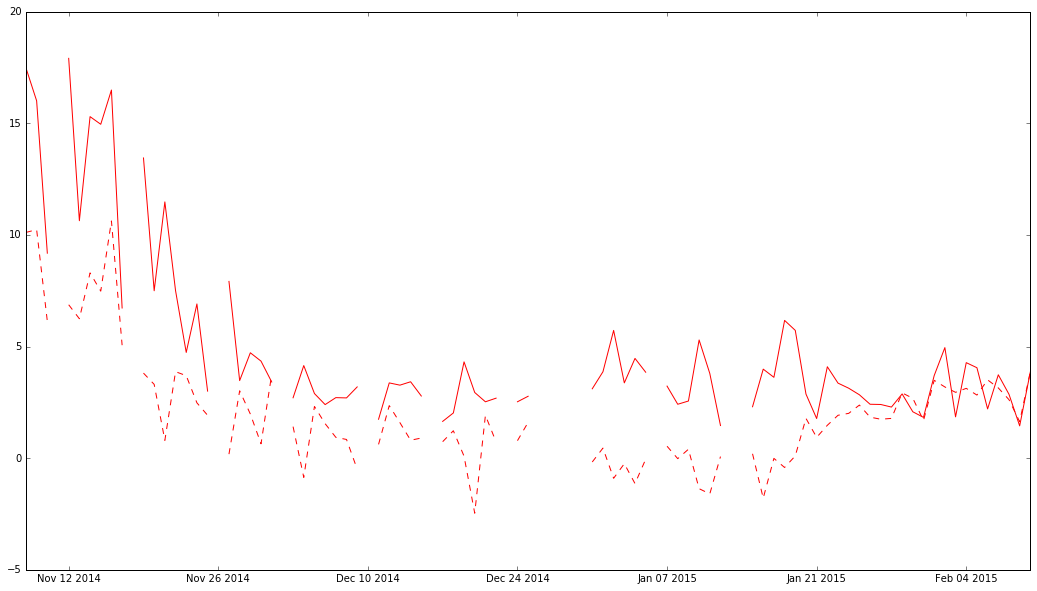

In [51]:
Graph = plt.figure(figsize=(18,10))
Colors = ['red','green','blue']
lines = ['--','--','-','-']
Widths = [1,2,1,2]
Dates = ['2015-01-07','2015-01-30']
Pos = 0
Filter = (EnergyBalance.ix[:,'Rn-G'] > 0.5)
for Cult in ['Dash']:#Cultivars:
    for Irr in ['High']:
        ToTa = EnergyBalance.ix[Filter].groupby(level=['Cultivar','Irrigation','Date'],axis=0).mean().ix[(Cult,Irr),'To-Ta'].resample('d').mean()
        ToULTa = EnergyBalance.ix[Filter].groupby(level=['Cultivar','Irrigation','Date'],axis=0).mean().ix[(Cult,Irr),'ToUL-Ta'].resample('d').mean()
        xData = ToTa.index
        plt.plot(xData,ToTa,'--',color=Colors[Pos],linewidth=Widths[Pos])
        plt.plot(xData,ToULTa,'-',color=Colors[Pos],linewidth=Widths[Pos])
        Pos+=1


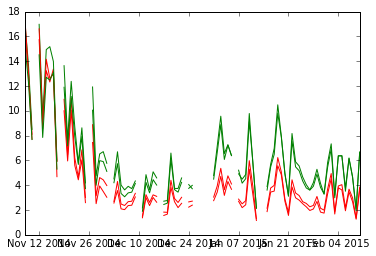

In [52]:
fig = Comparison.add_subplot(6,2,Position)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.ix[:,'Rn-G'] > 0.2)
        yData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'ToUL-Ta'].groupby(level='Date',axis=0).mean().resample('d').mean()
        #yData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'To-Ta'].groupby(level='Date',axis=0).mean().resample('d').mean()/EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'ToUL-Ta'].groupby(level='Date',axis=0).mean().resample('d').mean()
        xData = yData.index
        plt.plot(xData,yData,'-', color =  Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=10,mew=2)
        ColorPosition += 1
        FillPosition += 1


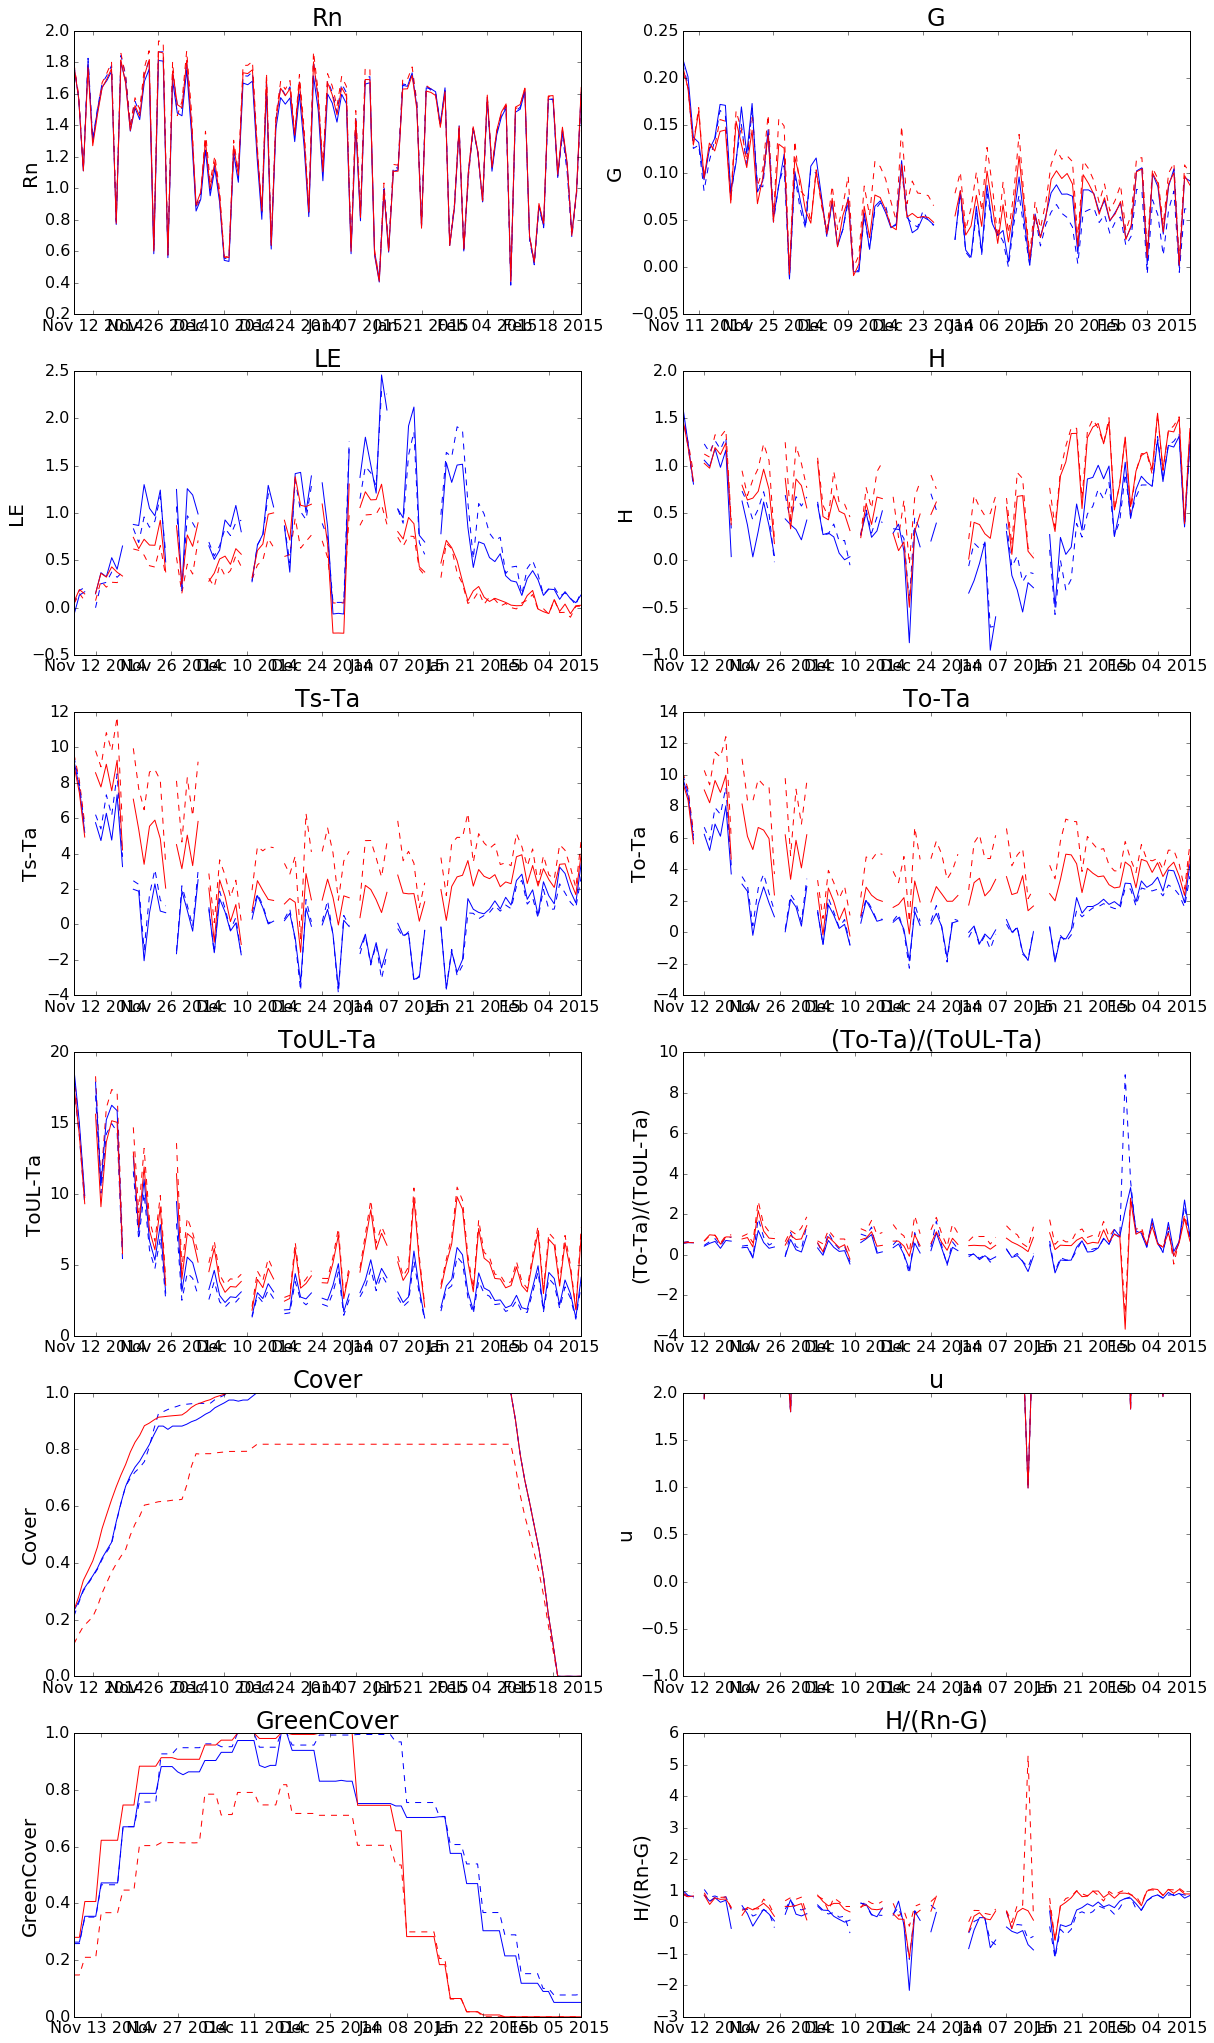

In [53]:
Comparison = plt.figure(figsize = (20,60))

Colors = ['blue','red','green']
Variables = ['Rn','G','LE','H','Ts-Ta','To-Ta','ToUL-Ta','(To-Ta)/(ToUL-Ta)','Cover','u','GreenCover','H/(Rn-G)']
Lines = ['--','-']
Position = 1
for Var in Variables:
    fig = Comparison.add_subplot(10,2,Position)
    LinePos=0
    for Cultivar in Cultivars:
        ColorPosition = 0   
        for Irrigation in IrrigationsSub:
            Filter = EnergyBalance.Rn > 0.1 
            yData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),Var].groupby(level='Date',axis=0).mean().resample('d').mean()
            xData = yData.index.get_level_values('Date')
            plt.plot(xData,yData, Lines[LinePos], color = Colors[ColorPosition],label = Cultivar+Irrigation)
            ColorPosition += 1
        plt.ylabel(yData.name, fontsize= 20)
        LinePos +=1
    plt.tick_params(labelsize = 16)
    if Position == 10:
        plt.ylim(-1,2)
    plt.title(Var, fontsize = 24)
    Position +=1


(-1, 2)

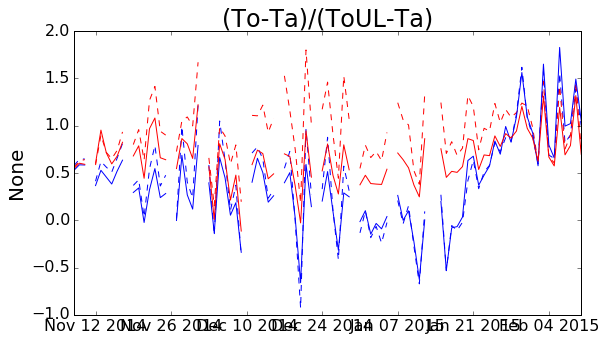

In [54]:
Comparison = plt.figure(figsize = (20,60))

Colors = ['blue','red','green']
Variables = ['(To-Ta)/(ToUL-Ta)']
Lines = ['--','-']
Position = 1
for Var in Variables:
    fig = Comparison.add_subplot(10,2,Position)
    LinePos=0
    for Cultivar in Cultivars:
        ColorPosition = 0   
        for Irrigation in IrrigationsSub:
            Filter = EnergyBalance.Rn > 0 
            yData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'To-Ta'].groupby(level='Date',axis=0).mean().resample('d').mean()/EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'ToUL-Ta'].groupby(level='Date',axis=0).mean().resample('d').mean()
            xData = yData.index.get_level_values('Date')
            plt.plot(xData,yData, Lines[LinePos], color = Colors[ColorPosition],label = Cultivar+Irrigation)
            ColorPosition += 1
        plt.ylabel(yData.name, fontsize= 20)
        LinePos +=1
    plt.tick_params(labelsize = 16)
    if Position == 10:
        plt.ylim(-1,2)
    plt.title(Var, fontsize = 24)
    Position +=1
plt.ylim(-1,2)

(-4, 12)

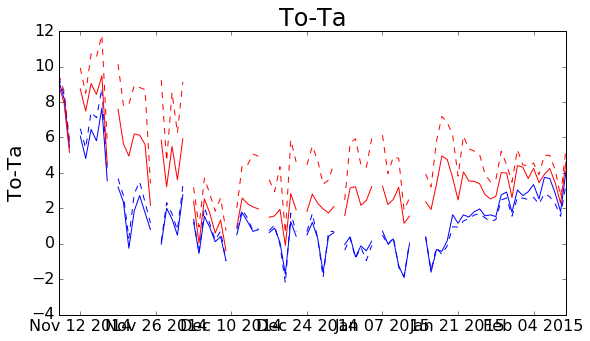

In [55]:
Comparison = plt.figure(figsize = (20,60))

Colors = ['blue','red','green']
Variables = ['To-Ta']
Lines = ['--','-']
Position = 1
for Var in Variables:
    fig = Comparison.add_subplot(10,2,Position)
    LinePos=0
    for Cultivar in Cultivars:
        ColorPosition = 0   
        for Irrigation in IrrigationsSub:
            Filter = EnergyBalance.Rn > 0 
            yData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),Var].groupby(level='Date',axis=0).mean().resample('d').mean()
            xData = yData.index.get_level_values('Date')
            plt.plot(xData,yData, Lines[LinePos], color = Colors[ColorPosition],label = Cultivar+Irrigation)
            ColorPosition += 1
        plt.ylabel(yData.name, fontsize= 20)
        LinePos +=1
    plt.tick_params(labelsize = 16)
    if Position == 10:
        plt.ylim(-1,2)
    plt.title(Var, fontsize = 24)
    Position +=1
plt.ylim(-4,12)

(1, 15)

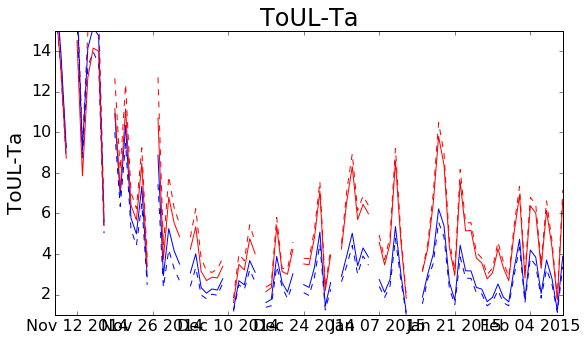

In [56]:
Comparison = plt.figure(figsize = (20,60))

Colors = ['blue','red','green']
Variables = ['ToUL-Ta']
Lines = ['--','-']
Position = 1
for Var in Variables:
    fig = Comparison.add_subplot(10,2,Position)
    LinePos=0
    for Cultivar in Cultivars:
        ColorPosition = 0   
        for Irrigation in IrrigationsSub:
            Filter = EnergyBalance.Rn > 0 
            yData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),Var].groupby(level='Date',axis=0).mean().resample('d').mean()
            xData = yData.index.get_level_values('Date')
            plt.plot(xData,yData, Lines[LinePos], color = Colors[ColorPosition],label = Cultivar+Irrigation)
            ColorPosition += 1
        plt.ylabel(yData.name, fontsize= 20)
        LinePos +=1
    plt.tick_params(labelsize = 16)
    if Position == 10:
        plt.ylim(-1,2)
    plt.title(Var, fontsize = 24)
    Position +=1
plt.ylim(1,15)

KeyError: 'ResH/(Rn-G)'

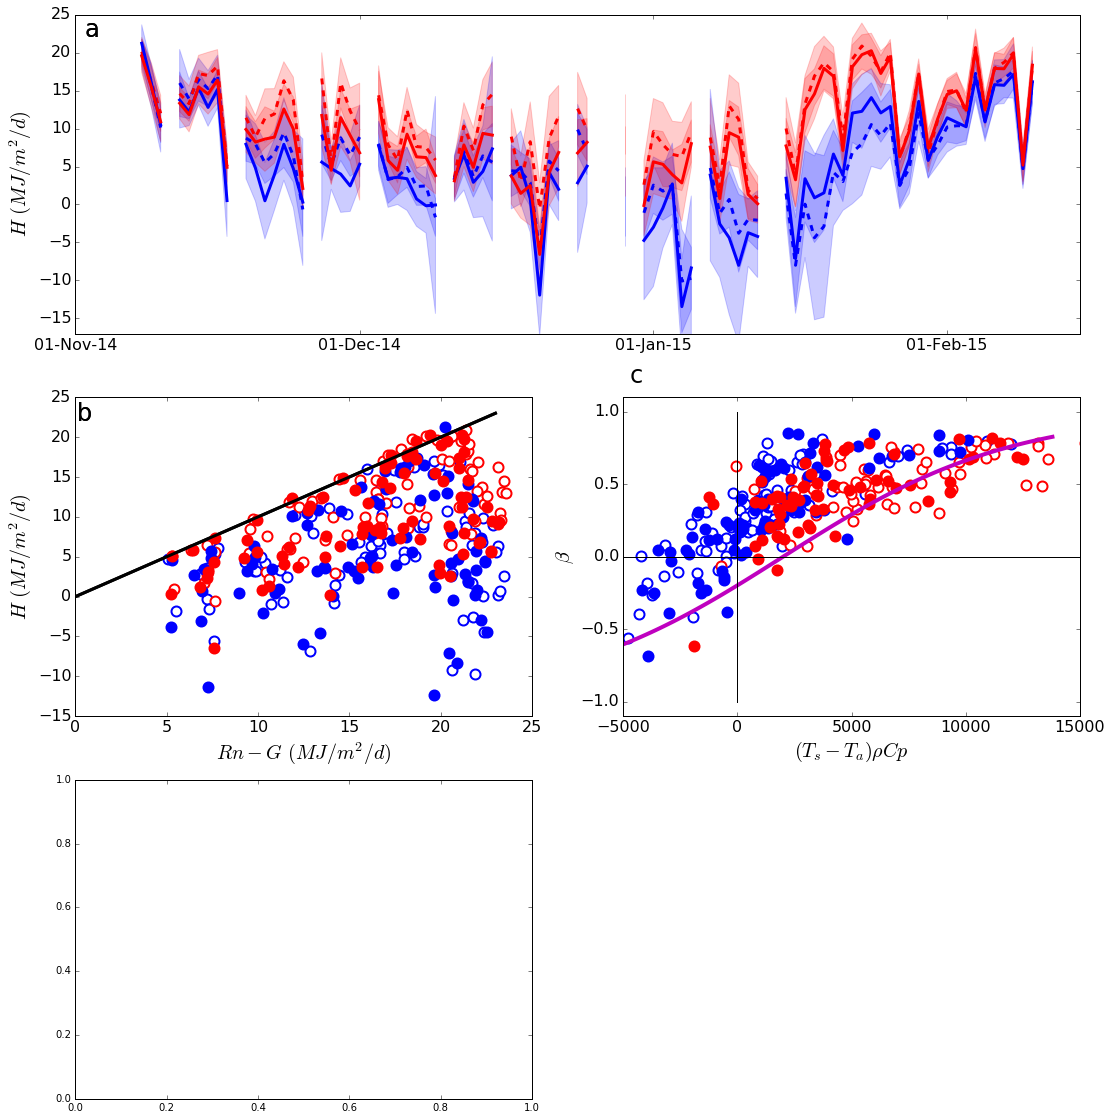

In [57]:
Comparison = plt.figure(figsize = (18,40))
Tit = ['a','b','c','d','e','f','g','h','i','j','k']
Colors = ['blue','red']
FillColors = ['White','White','blue','red']
Lines = ['--','-']
Position = 1
fig = Comparison.add_subplot(6,1,Position)
LinePos=0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = EnergyBalance.Rn > 0.01 
        yData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'H'].groupby(level='Date',axis=0).mean().resample('d').sum()
        ySEM = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'H'].groupby(level='Date',axis=0).std().resample('d').sum()
        Upp = yData + ySEM
        Low = yData - ySEM
        xData = yData.index.get_level_values('Date')
        plt.plot(xData,yData, Lines[LinePos], color = Colors[ColorPosition],label = Cultivar+Irrigation,linewidth = 3)
        plt.fill_between(xData,Upp,Low,color = Colors[ColorPosition],alpha=0.2)
        ColorPosition += 1
    plt.ylabel('$H$ $(MJ/m^2/d)$', fontsize= 20)
    plt.ylim(-17,25)
    LinePos +=1
    fig.xaxis.set_major_locator(mdates.MonthLocator())
    fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
    plt.xlim('2014-11-01','2015-02-15')
    plt.text('2014-11-02',22, 'a', fontsize = 24)
plt.tick_params(labelsize = 16)
Position +=2

fig = Comparison.add_subplot(6,2,Position)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.Rn > .1)
        yData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'H'].groupby(level='Date',axis=0).mean().resample('d').sum()
        xData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'Rn-G'].groupby(level='Date',axis=0).mean().resample('d').sum()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=10,mew=2)
        ColorPosition += 1
        FillPosition += 1
    plt.ylabel('$H$ $(MJ/m^2/d)$', fontsize= 20)
    plt.xlabel('$Rn-G$ $(MJ/m^2/d)$', fontsize= 20)
    plt.tick_params(labelsize = 16)
    plt.ylim(-15,25)
    plt.xlim(0,25)
    plt.text(0.1,22, 'b', fontsize = 24)
    plt.plot([0,23],[0,23],'-',color='k',linewidth=3)
Position +=1

fig = Comparison.add_subplot(6,2,Position)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0 
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.ix[:,'Rn-G'] > 0.5)&(EnergyBalance.ix[:,'LE'] > 0.1)\
        &(EnergyBalance.ix[:,'abs(H/(Rn-G))'] <1.05)&(EnergyBalance.ix[:,'uVPD']>0)\
        &(EnergyBalance.GreenCover>0.0)
        yData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'H/(Rn-G)'].groupby(level='Date',axis=0).mean().resample('d').mean()
        xData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'(Ts-Ta)qCp'].groupby(level='Date',axis=0).mean().resample('d').mean()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=10,mew=2)
        ColorPosition += 1
        FillPosition += 1
# yData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'EstH/(Rn-G)'].groupby(level='Date',axis=0).mean().resample('h').mean()
# xData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'(Ts-Ta)qCp'].groupby(level='Date',axis=0).mean().resample('h').mean()
# plt.plot(xData,yData,'o', mec = 'm', mfc = 'm', label = Irrigation,markersize=2,mew=2)
Xs = range(-6000,14000,200)
Ys1 = []
Ys0 = []
for x in Xs:
    y1 = 2/(1+np.exp((x+-2000)*-.0002)) - (2/2)
    y0 = C0/(1+np.exp((x+0)*-.001)) - (C0/2)
    Ys1.append(y1)
    Ys0.append(y0)
plt.plot(Xs,Ys1,'-',color='m',linewidth=4)
#plt.plot(Xs,Ys0,'-',color='c',linewidth=4)
plt.plot([0,0],[-1,1],'k')
plt.plot([-15000,15000],[0,0],'k')
plt.ylabel(r'$\beta $', fontsize= 20)
plt.xlabel(r'$(T_s-T_a) \rho Cp$', fontsize= 20)
plt.tick_params(labelsize = 16)
plt.ylim(-1.1,1.1)
plt.xlim(-5000,15000)
plt.text(-4700, 1.2, 'c', fontsize = 24)
Position +=1

fig = Comparison.add_subplot(6,2,Position)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.Rn > .5)&(EnergyBalance.LE > .1)\
        &(EnergyBalance.ix[:,'abs(H/(Rn-G))'] <1.05)&(EnergyBalance.ix[:,'uVPD']>6)
        yData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'ResH/(Rn-G)'].groupby(level='Date',axis=0).mean().resample('d').mean()
        xData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'u'].groupby(level='Date',axis=0).mean().resample('d').mean()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=10,mew=2)
        ColorPosition += 1
        FillPosition += 1
    plt.ylabel(r'$res(\beta)$', fontsize= 20)
    plt.xlabel('$fPAR_{green}$', fontsize= 20)
    plt.tick_params(labelsize = 16)
    plt.ylim(-2,2)
    #plt.xlim(0,1)
    #plt.plot([0,CB,1],[(C0-C1)/2,0,0],'-',color='k',linewidth=2)
    plt.plot([0,0.8,1],[.4,-0.1,-0.1],'-',color='k',linewidth=2)
    #yData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'C'].groupby(level='Date',axis=0).mean().resample('d').mean()/2 - C1/2
    #xData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'GreenCover'].groupby(level='Date',axis=0).mean().resample('d').mean()
    #plt.plot(xData,yData,'-', mec = 'm', mfc = 'm', label = Irrigation,markersize=2,mew=2)
    plt.text(0.02, 0.8, 'd', fontsize = 24)
Position +=1

fig = Comparison.add_subplot(6,2,Position)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.Rn > .5)&(EnergyBalance.ix[:,'abs(H/(Rn-G))'] <1.05)\
        &(EnergyBalance.ix[:,'Cover']>0.7)&(EnergyBalance.LE>0.1)
        yData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'ResH/(Rn-G)2'].groupby(level='Date',axis=0).mean().resample('d').mean()
        xData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'uVPD'].groupby(level='Date',axis=0).mean().resample('d').mean()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=10,mew=2)
        ColorPosition += 1
        FillPosition += 1
    plt.ylabel(r'$res(\beta)$', fontsize= 20)
    plt.xlabel('$Wind$ $speed$ $(m/s)$', fontsize= 20)
    plt.tick_params(labelsize = 16)
    plt.ylim(-1,1)
    plt.plot([0,4,8],[.5,0,0],'-',color='k',linewidth=2)
    #plt.text(0.2, 0.8, 'e', fontsize = 24)
Position +=1

In [ ]:
EnergyBalance.to_csv('.\DataFrames\EnergyBalanceData.csv')

## Look at sensible heat data in relation to canopy temp depression

In [ ]:
Descriptors = ['Ts-TaqCp','GreenCover']
Filter = (EnergyBalance.Rn > 0.6)#&(EnergyBalance.Ra <300)&(EnergyBalance.Ra>2)
X = EnergyBalance.ix[Filter,EnergyBalance.columns.isin(Descriptors)]
Y = EnergyBalance.ix[Filter,'H/(Rn-G)']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Regres.summary()

In [ ]:
fig = plt.Figure()
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0 
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.ix[:,'Rn-G'] > 0.5)&(EnergyBalance.ix[:,'LE'] > 0.1)\
        &(EnergyBalance.ix[:,'abs(H/(Rn-G))'] <0.05)&(EnergyBalance.ix[:,'uVPD']>0)\
        &(EnergyBalance.GreenCover>0)
        yData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'Ts-Ta'].groupby(level='Date',axis=0).mean().resample('d').mean()
        xData = EnergyBalance.ix[Filter].ix[(Cultivar,Irrigation),'VPD'].groupby(level='Date',axis=0).mean().resample('d').mean()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=10,mew=2)
        ColorPosition += 1
        FillPosition += 1
#plt.plot([0,3],[1500,-7500])